# **Modeling**

##### **Import Packages**

In [187]:
import os
# Resolve an error that I had with Cuda
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.utils import to_categorical


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans

from tqdm import tqdm

plt.style.use('dark_background')

**Set the Directory**

In [2]:
# Change the directory to Capstone 2
os.chdir(r'C:\Users\jdrel\OneDrive\Documents\Data_Science\Springboard\Capstone-2')

#### **Load the Data**

In [3]:
# Import the small training set
small_train = pd.read_csv('./data/processed/small_train.csv')

# Import the small test set
small_test = pd.read_csv('./data/processed/small_test.csv')

# Import the small training set
big_train = pd.read_csv('./data/processed/big_train.csv')

# Import the small test set
big_test = pd.read_csv('./data/processed/big_test.csv')

Now that I have loaded the datasets, I need to separate out the features (X) from the target variable (y) so that it is easy to run the models. 

In [4]:
# Create the X which is only features in the training data
X_small = small_train.drop(['labels', 'group'], axis = 1)
# Create X small for the test set
X_small_test = small_test.drop(['labels', 'group'], axis = 1)
# Do the same thing for the bigger data set
X_big = big_train.drop(['labels', 'group'], axis = 1)
# Create X big for the test set
X_big_test = big_test.drop(['labels'], axis = 1)
# Create the binary y for the training set.
y_train_binary = pd.DataFrame(np.where(small_train['labels'] == 'normal.', 0, 1), columns = ['Binary'])
# Combine labels and binary so that I can analyze which intrusions did well
y_train = pd.concat([small_train['labels'], y_train_binary], axis = 1)
# Create the binary y for the test set
y_test_binary = pd.DataFrame(np.where(small_test['labels'] == 'normal.', 0, 1), columns= ['Binary'])
# Combine labels and binary so that I can analyze which intrusions did well
y_test = pd.concat([small_test['labels'], y_test_binary], axis = 1)

##### **GPU Integration**

I wanted to use a gpu for my neural network to speed up the processing significantly. I first tried the Keras API since that is the simplest learning modeule in Python. Unfortunately tensorflow-gpu has discontinued support for Windows so I would have had to downgrade of many of the packages in this environment to be able to use an older version of tensorflow-gpu that is Windows compatible. 

I then saw that while tensorflow-gpu doesn't support Windows, it still supports Linux. I installed Windows Subsystem for Linux (WSL) and tried a remote session in VScode through Linux to use tensorflow gpu. After many failed attempts of a crashed kernels, I was able to get my gpu to run the neural networks with tensorflow in the Linux distribution in WSL. Sadly it took significantly longer to run tensorflow-gpu in Linux than it did to run tensorflow on the cpu in Windows. The WSL Linux system is missing many of the GPU optimizations that would make it faster than the cpu. I did not have the time to figure out how to optimize the GPU for WSL.

My last hope was to try Pytorch on Windows since Pytorch hasn't discontinued Windows support. I didn't know how to use Pytorch well but since I have already built the models with the Keras API, I asked chatGPT to translate the code from Keras to Pytorch. The translation wasn't perfect but after a few fixes I ran the neural net with Pytorch on the GPU. This did not accelerate the run time because there is an initial time cost of converting the model to the GPU before it can run. 

Below I test to see if Pytorch is able to detect my NVIDIA GPU

In [5]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the GPU
    print("GPU is available")
else:
    device = torch.device("cpu")  # Use the CPU
    print("GPU is not available, using CPU")

GPU is available


My computer has two GPUs. An Intel GPU for videos and graphics in normal computing and an NVIDIA GPU for gaming. The code below is to set the GPU that Pytorch is using to NVIDIA.

In [6]:
# Set the GPU through the name cuda
torch.device("cuda")

device(type='cuda')

## **Neural Networks**

#### **Define Model Functions**

The biggest difference between Keras and Pytorch is the need to create with Pytorch many of the methods that Keras has already defined. Below I created a function that simulated the .fit() method of Keras with pytorch. I could have included the loss function and optimizer as arguments but I wanted to see how the model performed before I started hyper-parameter tuning.

In [7]:
# Create a fit function that takes the X-train, y-train, epochs and Batch Size and fits the model
def train_model(X_train, y_train, epochs, batch_sizes, net):
    y_train = np.array(y_train['Binary'])

    # Create an instance of the model with the correct input_dim
    model = net(X_train.shape[1])

    # Check if the GPU is available and save it to device. If not use the cpu
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Move the model over to the device that is available
    model.to(device)

    # Define the loss function
    criterion = nn.BCELoss()

    # Define the optimizer
    optimizer = optim.Adam(model.parameters())

    X_train_tensor = torch.Tensor(X_train.values).float().to(device)
    y_train_tensor = torch.Tensor(y_train).float().to(device)

    # Training loop
    num_epochs = epochs
    batch_size = batch_sizes
    global losses
    losses = []
    for epoch in range(num_epochs):
        # Shuffle the data at the start of each epoch
        indices = np.random.permutation(len(X_train_tensor))
        shuffled_X = X_train_tensor[indices]
        shuffled_y = y_train_tensor[indices]
        
        # Set the model to training mode
        model.train()

        # Mini-batch training
        for i in range(0, len(X_train_tensor), batch_size):

            batch_X = shuffled_X[i:i+batch_size]
            batch_y = shuffled_y[i:i+batch_size]

            # Forward pass
            outputs = model(batch_X)
            outputs = outputs.view(-1)
            loss = criterion(outputs, batch_y)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute accuracy
            predicted_labels = (outputs > 0.5).float()
            accuracy = (predicted_labels == batch_y).float().mean()
        

            # Print loss and accuracy
            print(f'\rEpoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(X_train_tensor)}], Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}', end = '\r')
        
        losses.append(loss.item()) # type: ignore
    
    return model

The above function returns the total loss for each epoch that is run in the training of the model. Below I created a function to plot that loss where the x-axis is the epoch number and the y-axis is the loss.

In [215]:
# Create a function that takes in the loss from the train_model as an argument
def loss_plot(loss, param_k = False, ticks_k = False):
    if ticks_k == False:
        # Create a plot of the the epics and the losses for each epoch
        plt.plot(range(1,len(loss) + 1), loss);
        # Match the ticks to the epochs
        plt.xticks(np.arange(1, len(loss) + 1));
    else:
        # Create a plot of the the epics and the losses for each epoch
        plt.plot(range(ticks_k[0], ticks_k[1]), loss); # type: ignore
        # Match the ticks to the epochs
        plt.xticks(np.arange(ticks_k[0], ticks_k[1] + 1)); # type: ignore
    if param_k == False:
        # Label the x-axis of the graph
        plt.xlabel("Epoch #");
    else:
        # Label the x-axis of the graph
        plt.xlabel("K - Value");
    # Label the y-axis of the graph
    plt.ylabel("Cost");
    # Title the graph
    plt.title("Model Cost");

With a trained model I needed a function that would use that model to predict outcomes from the test set features while also giving a classification report.
The classification report measures precision, recall, accuracy, and f-1 score and is a great way to measure the models performance. This evaluation function is only meant for binary classifications.

In [9]:
# Create a function to evaluate the model
def eval_model(X_test, y_test, model):
    # Set the model to evaluation mode
    model.eval()

    # Move the model and data back to the CPU
    model.to("cpu")
    X_test_tensor = torch.Tensor(X_test.values).float()

    # Make Preds a global variable for the roc graph
    global preds
    # Perform predictions on the test set
    with torch.no_grad():
        preds = model(X_test_tensor)

    # Convert the predictions tensor to a numpy array
    preds = preds.numpy()

    # Classify the predicitions as 0 or 1 since the values the sigmoid produces are not exact
    preds = np.where(preds < .5, 0, 1)

    # Print the classification report 
    print(classification_report(y_test['Binary'], preds, zero_division = 0))

While the classification_report gives an overall sense of how the model did I still needed a way to evaluate how well the model handled each intrusion type. The function below takes the predictions and real values and returns a table of all the intrusion types, how many times the model predicted them correctly, wrongly, the net difference and the percentage of correct predictions.

In [154]:
# Define a function that examines how the new intrusion types did
def ints_eval(preds, test, multi = False, new_int = True):
    global new_attacks
    # Create a list of all the new attack types. This list was taken from preprocessing notebook
    new_attacks = ['xsnoop.', 'udpstorm.', 'mscan.', 'named.', 'processtable.', 'xlock.', 'snmpgetattack.', 
               'snmpguess.', 'worm.', 'ps.', 'httptunnel.', 'sendmail.', 'saint.', 'mailbomb.', 'apache2.', 'xterm.', 'sqlattack.']
    if new_int == True:
        mask = test['labels'].isin(new_attacks)
        # create a dataframe that is a column of labels that only has the new labels
        new_labels = pd.DataFrame(test['labels'][mask], columns = ['labels']).reset_index(drop=True)
        # create a dataframe that is a column of labels that only has the predictions
        pred_df = pd.DataFrame(preds[mask], columns = ['pred']).reset_index(drop=True)
        # Combine the labels and the predictions for analysis
        new_intrusions = pd.concat([new_labels, pred_df], axis = 1)
    else:
        # create a dataframe that is a column of labels that only has the new labels
        new_labels = test.reset_index(drop=True)
        # create a dataframe that is a column of labels that only has the predictions
        pred_df = pd.DataFrame(preds, columns = ['pred']).reset_index(drop=True)
        # Combine the labels and the predictions for analysis
        new_intrusions = pd.concat([new_labels, pred_df], axis = 1)
    # For binary evaluation
    if multi == False:
        # Initialize cni and wni as pandas series
        cni = pd.Series(dtype=float, index = test['labels'].unique()).fillna(0)
        wni = pd.Series(dtype=float, index = test['labels'].unique()).fillna(0)
        # Iterate through all the predictions
        for i, bin in tqdm(enumerate(test['Binary']), total = test.shape[0]):
            # Select all the correct predictions
            if preds[i] == bin:
                # Add 1 to the count everytime there is a correct prediction
                cni[test.iloc[i,0]] += 1
            # If it isn't correct
            else:
                # Add one to the incorrect guesses
                wni[test.iloc[i,0]] +=1
    else:
        # Initialize cni and wni as pandas series
        cni = pd.Series(dtype=float, index = test['labels'].unique()).fillna(0)
        wni = pd.Series(dtype=float, index = test['labels'].unique()).fillna(0)
        # Iterate through all the predictions
        for i, group in tqdm(enumerate(test['group']), total = test.shape[0]):
            # Select all the correct predictions
            if preds[i] == group:
                # Add 1 to the count everytime there is a correct prediction
                cni[test.iloc[i,0]] += 1
            # If it isn't correct
            else:
                # Add one to the incorrect guesses
                wni[test.iloc[i,0]] +=1
    # Join the right and wrong counts
    deep_dive = pd.concat([cni,wni],axis = 1)
    # Change the column names to indicate what the counts mean
    deep_dive.columns = ["Correct", "Wrong"]
    # fill in the NaN values since some attacks had no correct predictions
    deep_dive = deep_dive.fillna(0)
    # Convert the correct column to the integer type
    deep_dive["Correct"] = deep_dive["Correct"].astype(int)
    # Create a Net column to show the best and worst new intrusions for the model
    deep_dive["Net"] = deep_dive["Correct"] - deep_dive["Wrong"]
    # Create a column showing the percent correct
    deep_dive["% Correct"] = round(deep_dive['Correct']/(deep_dive['Correct'] + deep_dive['Wrong'])*100,1)
    # Convert the wrong column to the integer type
    deep_dive["Wrong"] = deep_dive["Wrong"].astype(int)
    # Convert the net column to the integer type
    deep_dive["Net"] = deep_dive["Net"].astype(int)
    # Sort the dataframe so that it is easier to interpret
    deep_dive = deep_dive.sort_values(by = ['% Correct', 'Correct'], ascending = False)
    # return the data frame
    return deep_dive

##### **Neural Net Architecture**

Below I have created a model with 4 hidden layers that each have 12 nodes. I started out having as many nodes as features and then creating a decent amount of hidden layers. If the model is having significant problems in training, I will try different model architectures. 

In [11]:
# Define the model class Net from the parent class nn.Module
class Net(nn.Module):
    # Initialize the class with 
    def __init__(self, input_dim):
        # Initialize nn.Module with super
        super(Net, self).__init__()
        # Create the first layer of the neural net
        self.fc1 = nn.Linear(input_dim, 12)
        # Create the middle layers of the network with 12 nodes that connect to 12 nodes
        self.fc2 = nn.Linear(12, 12)
        self.fc3 = nn.Linear(12, 12)
        self.fc4 = nn.Linear(12, 12)
        # Create a layer that has 12 nodes that connect to 8 nodes
        self.fc5 = nn.Linear(12, 8)
        # Create the last layer that takes 8 nodes and compresses it down to 1
        self.fc6 = nn.Linear(8, 1)
        self.activation = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    # Define a method for the forward propagation of the model
    def forward(self, x):
        # Create the connections 
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.activation(self.fc5(x))
        x = self.sigmoid(self.fc6(x))
        return x

Over the course of the notebook I tried different model architectures and activations. Below is a model that is specifically for the extra features from a Lasso Regularization that I did later in the notebook that had more features than the initial data set I had been using.

In [12]:
# Define the model class Net from the parent class nn.Module
class testNet(nn.Module):
    # Initialize the class with 
    def __init__(self, input_dim):
        # Initialize nn.Module with super
        super(testNet, self).__init__()
        # Create the first layer of the neural net
        self.fc1 = nn.Linear(input_dim, 22)
        # Create the middle layers of the network with 12 nodes that connect to 12 nodes
        self.fc2 = nn.Linear(22, 22)
        self.fc3 = nn.Linear(22, 22)
        self.fc4 = nn.Linear(22, 12)
        # Create a layer that has 12 nodes that connect to 8 nodes
        self.fc5 = nn.Linear(12, 8)
        # Create the last layer that takes 8 nodes and compresses it down to 1
        self.fc6 = nn.Linear(8, 1)
        self.activation = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    # Define a method for the forward propagation of the model
    def forward(self, x):
        # Create the connections 
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.activation(self.fc5(x))
        x = self.sigmoid(self.fc6(x))
        return x

### **Small Data**
#### **Binary Models**

The first model that I'm going to run will use only the training data. The official test set contains new values so by using the training data as both the training and test set I can assess if a neural network is the right model for this dataset.

Below I split the data into training and test sets.

In [24]:
# Create a train and test data from the 12 feature dataset
X_train, X_test, y_tr, y_te = train_test_split(X_small, y_train, test_size = .25, random_state = 42)

#### **Running the Model**

I can now recall the function train_model() that I had created with the training data from train_test_split to train the neural network. When I ran the models at first I had set the batch size to 50 and it took a long time to run. I realized that when I set it in the thousands, the model became a lot faster.

In [15]:
# Train the model with the trainig dataset
nnettrain = train_model(X_train, y_tr, 10, 5000, Net)

The loss and accuracy are great. It shows that I did a good job in my data wrangling and preprocessing to come up with features that present clear patterns for the model to use.

Below is a plot of the loss function after each epoch. 

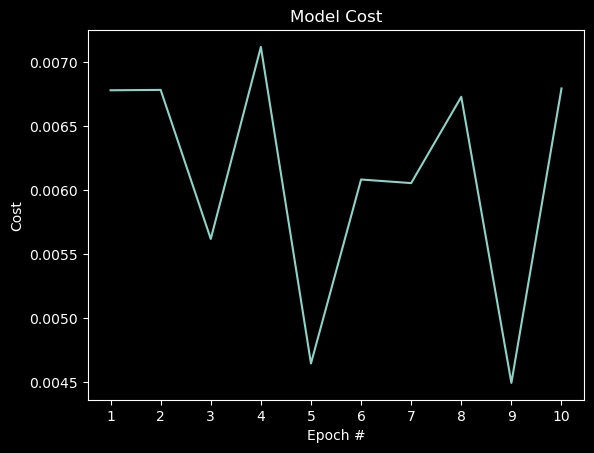

In [16]:
# Plot the loss with the loss that is returned by the train_model function
loss_plot(losses)

Because the model was able to train itself so quickly through the different batches in the first epoch, there is little difference in the resulting epochs which appear as random fluctuations. 

Now that I have a trained model on 75% of the data, I can use the last 25% of the data as a cross validational dataset to test the model.

In [18]:
# Evaluate the code with the eval_model function
eval_model(X_test, y_te, nnettrain)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    243103
           1       1.00      1.00      1.00    981505

    accuracy                           1.00   1224608
   macro avg       1.00      1.00      1.00   1224608
weighted avg       1.00      1.00      1.00   1224608



Wow. Classification report rounds its scores so this most likely wasn't a perfect result but it was very close to perfect. Now that I know that this model is very effective for this dataset I will use the entire dataset to train for the official test set.

Interestingly, Pytorch ended up being far faster as the predictions took significantly less time because Pytorch uses a dynamic computational graph instead of the static computational graph that tensorflow uses. The dynamic graph changes the architecture of model to be more efficient in evaluation which can lead to different results in some cases. As far as I can tell there is no significant difference between the two packages. 

Below I ran the training on the entire 12 feature dataset with this current neural net

In [45]:
nnetsmall = train_model(X_small, y_train, 10, 5000, Net)

This model was perfect in cross validation and has now been trained on the entirety of the training dataset. I will now save the model so that I or anyone else can access it for future use.

In [46]:
# Save the model to the model folder
torch.save(nnetsmall, './models/nnetsmall.pth')

Below I loaded the model in so that I don't have to train it everytime I use the notebook

In [19]:
# Load the model so that I don't keep having to compute the model
nnetsmall = torch.load('./models/nnetsmall.pth')
# Evaluate the madel with the test set
eval_model(X_small_test, y_test, nnetsmall)

              precision    recall  f1-score   support

           0       0.75      0.84      0.79     60592
           1       0.96      0.93      0.94    250436

    accuracy                           0.91    311028
   macro avg       0.85      0.88      0.87    311028
weighted avg       0.92      0.91      0.91    311028



At first glance this appears promising, The model is not only better than a coinflip, It is also significantly better than a null model that would predict the most frequent class every time. Given the disparity of the suppport classes the next thing to do is to find out how much of the dataset is intrusions.

In [20]:
# Convert y_test to a string
y_test = y_test.astype(str)
# Store the unique values and their counts in separate variables
vals, counts = np.unique(y_test, return_counts = True)
# Create value_counts(normalize=True) for np array
prop_counts = counts/len(y_test)
# print the % of observations with no intrusion
print(f'No Intrusion: {round(prop_counts[0]*100, 1)}%')
# print the % of observations with an intrusion
print(f'Intrusion: {round(prop_counts[1]*100,1)}%')

No Intrusion: 19.5%
Intrusion: 80.5%


Above we see that only 19.5% of the test set is safe. If I had predicted an intrusion every time, the classification report would have had a precision of 80 for intrusion, 100 for recall intrusion and zeroes on everything for no intrusion. 

To get a better understanding of how well the model performed I can use the Reciever under the Curve metric which measures the True Positive Rate (TPR) against the False Positive Rate (FPR). A ROC area of greater that 0.8 is good and an ROC curve of 0.9 or greater is excellent.

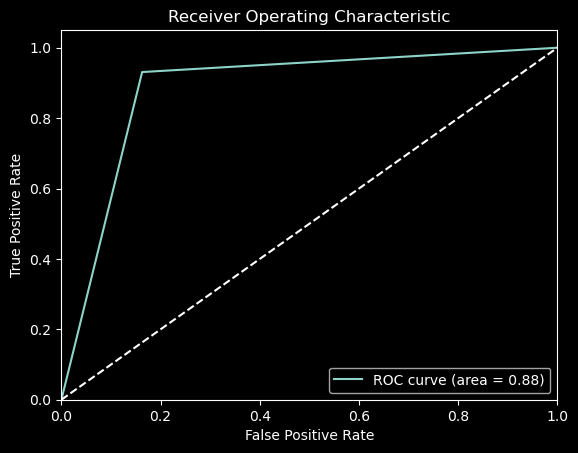

In [24]:
# Create an array of true in predictions
y_true = np.array(y_test['Binary']).astype(int)
# compute the false positive rate, true positive rate, and threshold for normal observations
fpr, tpr, thresholds = roc_curve(y_true, preds)

# calculate the AUC
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc);
# Plot the baseline 50-50 dashed line
plt.plot([0, 1], [0, 1], '--', color = 'w');
# Set the x axis limits
plt.xlim([0.0, 1.0]);
# Set the y axis limits
plt.ylim([0.0, 1.05]);
# Label the x-axis
plt.xlabel('False Positive Rate');
# Label the y-axis
plt.ylabel('True Positive Rate');
# Title the plot
plt.title('Receiver Operating Characteristic');
# Create the legend that has the area under the curve
plt.legend(loc="lower right");
# Show the graph
plt.show();

An ROC curve of .88 is really good but not great. 

There is a deeper issue with this result which is that when I compare it to the cv dataset there is a clear drop off. The most likely explanation for this is that the model failed to effectively predict that that the new attacks were not safe. This was the primary challenge of the Capstone and it appears that the model was not able to do an effective job.

Below I have isolated all the observations in the test set that contain new attack types and calculate the percentage of those observations that the model calculated as an attack.

In [50]:
# Create a mask for all values that are in new attacks in the test set
mask = small_test['labels'].isin(new_attacks)
# Use the mask to find all the prediction values that are from new labels
preds_new = preds[mask]
# Store the value count for the predictions
values, counts = np.unique(preds_new, return_counts = True)
# Print out the percent that is true positive
print(f"Percent of correctly identified new intrusions: {round((counts[1]/len(preds_new))*100, 2)}%")

Percent of correctly identified new intrusions: 14.24%


This is not good. Out of all the observations that had new attack types, only 14.24% were correctly classified by the model as an attack. 

To further investigate, I looked at which new attack types the model was best at predicting and which attack types the model struggled with.

In [218]:
deep_dive = ints_eval(preds, y_test)
# Show the deep dive dataframe
deep_dive.sort_values(['% Correct','Net'], ascending = False)

,Correct,Wrong,Net,% Correct
xsnoop.,4,0,4,100.0
sqlattack.,2,0,2,100.0
apache2.,790,4,786,99.5
processtable.,729,30,699,96.0
saint.,701,35,666,95.2
xlock.,4,5,-1,44.4
ps.,7,9,-2,43.8
named.,7,10,-3,41.2
xterm.,5,8,-3,38.5
sendmail.,5,12,-7,29.4


I believe that the varying efficiency of the model is because there is a wide range in the level of similarity between the new attacks and the training attacks that the model trained on. For snmpgetattack, mailbomb and snmpguess there weren't a lot of intrusions that had the same signature as them. Since the safe classification is likely to not have any specific markers, anything that didn't match an intrusion would be considered safe. 

There is a fundamental problem in this challenge which is that it is impossible to train for what has never happened. These models are great at predicting the future based on the patterns of the past but when they are unable to see any future patterns in the data they use then the algorithms will fail. This is why white hat hackers and consistently updating the training sets with new types of is crucial. Without data that has the patterns of the future we are blind to the new ways hackers may attack us.

To test if the Neural network is still viable, I can split the official test set in to training and testing data and see how the model performs on the subset of test data after having trained on the testing data. If this were a company or the government, eventually future observations would replace the test data and turn it in to training data. 

Below I run the model on the test set having split it into a training and test set

In [254]:
# Create a train and test data from the 12 feature dataset
X_test_train, X_test_test, y_test_tr, y_test_te = train_test_split(X_small_test, y_test, test_size = .25, random_state = 42)

Now I train the model with the same model architecture that I have been using for the other calculations.

In [256]:
nnettest = train_model(X_test_train, y_test_tr, 10, 50, Net)

The accuracy displayed here is for each batch and not for each epoch of training. With each batch only containing 50 observations it fluctuate wildly without giving the real number.

Below is a plot of the loss function over the epochs.

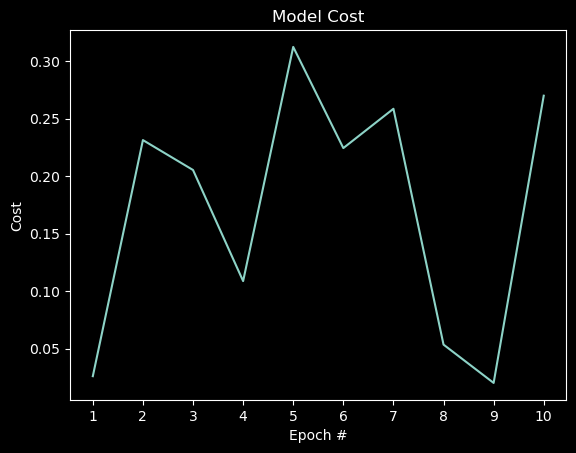

In [257]:
loss_plot(losses)

The model had for the most part fully trained by the end of first epoch.

In [258]:
eval_model(X_test_test, y_test_te, nnettest)
preds_1 = preds

              precision    recall  f1-score   support

           0       0.81      0.99      0.89     15035
           1       1.00      0.95      0.97     62722

    accuracy                           0.95     77757
   macro avg       0.91      0.97      0.93     77757
weighted avg       0.96      0.95      0.96     77757



The accuracy is not near the training set cross validational accuracy which is disappointing. It appears that all the clear patterns that were in the training set are not fully in the test set. When I did lasso regularization, I did it only with the training set which did not have any of the new attacks. This current dataset is optimized for the attacks in the training set but not the attacks in the test set. 

I'm still curious as to which attacks the model did well against regardless the dataset not having all the relevant features. I can use ints_eval to return a table with all the new intrusion types and how the model did with them.

In [259]:
deep_dive = ints_eval(preds_1,y_test_te)
# Show the deep dive dataframe
deep_dive

100%|██████████| 77757/77757 [00:03<00:00, 23547.38it/s]


,Correct,Wrong,Net,% Correct
neptune.,14629,4,14625,100.0
back.,259,0,259,100.0
portsweep.,89,0,89,100.0
nmap.,19,0,19,100.0
teardrop.,3,0,3,100.0
ftp_write.,1,0,1,100.0
phf.,1,0,1,100.0
smurf.,40971,21,40950,99.9
mailbomb.,1202,1,1201,99.9
mscan.,263,1,262,99.6


The model treats snmp intrusions from this dataset exact same as no intrusion. In my cluster analysis I explored how a combination of different traits can lead to some stark conclusions about the type of intrusion an observation contains. I can look at all means of the features of the observations that were snmp intrusions and compare them to the to the means of features in safe observations.

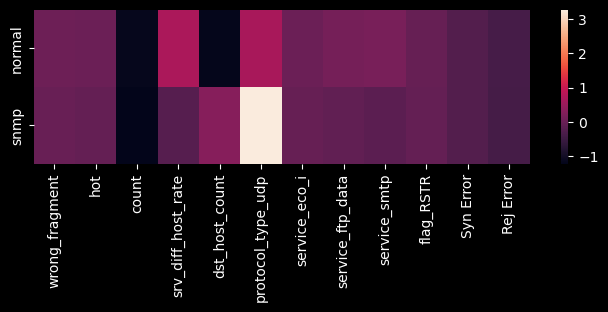

In [189]:
# Create groupby object
normal_mean = pd.DataFrame(small_test.loc[small_test['labels'] == 'normal.'].mean(numeric_only = True))
# Change the figure size to fit the dataframe
plt.figure(figsize=(8,2))
# filter out all observations that are snmp attacks
snmp = pd.DataFrame(small_test.loc[small_test['labels'].str.startswith('snmpg')].mean(numeric_only = True))
# combine the two
combined = pd.concat([normal_mean, snmp], axis = 1)
# Label the indices to know which is which
combined.columns = ['normal', 'snmp']
# create a heatmap of the means to visualize it better
sns.heatmap(combined.T);

The heatmap looks like there should be enough for snmp to classified correctly by the model as protocol_type_udp which would appear to be significantly different in SNMP. What most likely happened was that the model discarded protocol_type_udp during training as it didn't have a significant impact on the training intrusions. If I create a sequential second layer that re-examines all of the observations that the model predicted were safe, I can hopefully catch some obscurred patterns in the rarer intrusion types that could significantly improve the model.

This heatmap makes it look very possible to create a classifier that could differentiate between snmp and normal. One method that comes to mind is KMeans which will differentiate between snmp and normal given the difference they both display with their means. Below I tried to find a value of K that was suitable for all the observations that were either normal or snmp.

100%|██████████| 20/20 [00:20<00:00,  1.00s/it]


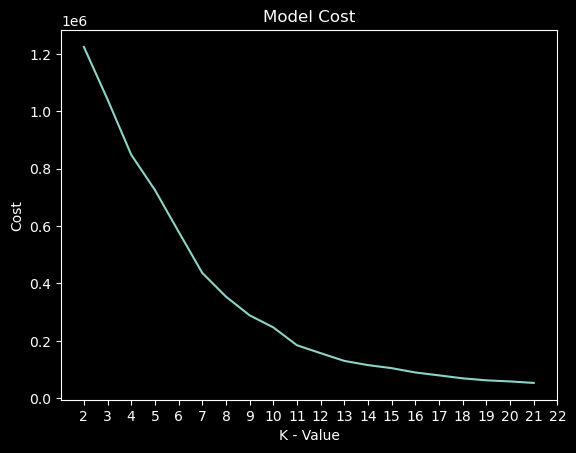

In [260]:
# Create a normal dataframe from the test set by making every label = normal.
normal = pd.DataFrame(small_test.loc[small_test['labels'] == 'normal.'])
# Drop the target variables that would destroy KMeans
X_normal = normal.drop(['labels','group'], axis = 1)
worst_performers = list(deep_dive.index[-13:])
# Create the snmp dataframe
snmp = pd.DataFrame(small_test.loc[small_test['labels'].isin(worst_performers)])
# drop the target variables
X_snmp = snmp.drop(['labels','group'], axis = 1)
# Concatenate the variables into a working dataframe
X_combined = pd.concat([X_normal, X_snmp], axis = 0)

# Initialize the loss function for the ks
kmeans_losses = []
# Create a loop to iterate over k
for k in tqdm(range(2,22)):
    # Initialize the KMeans classifier for values of k
    kmeans = KMeans(n_clusters=k, n_init = 10)
    # Fit the classifier to the normal and snmp data.
    kmeans.fit(X_combined)
    # Append the losses to the loss list
    kmeans_losses.append(kmeans.inertia_)

# Create a plot showing the loss for each value of k
loss_plot(kmeans_losses,param_k = True, ticks_k = [2,22]) # type: ignore


While there is no clear value of K it is clear that the clustering is effective as the line is decreasing significantly

In [261]:
# Create the full combined dataset with the target variables
combined = pd.concat([normal, snmp], axis = 0)
# Initialize the KMeans object with K = 10
kmeans = KMeans(n_clusters=10, n_init = 10)
# Fit the data to the kmeans clusterer
kmeans.fit(X_combined)
# store the clusters in the combined dataframe
combined['clusters'] = kmeans.predict(X_combined)
# Convert the labels over to binary for analysis
combined['labels'] = np.where(combined['labels'] == 'normal.', 0, 1)
# group by cluster to see if there is anything interesting in the clusters
combined.groupby('clusters').agg({'labels':['mean','count']})

labels       
              mean  count
clusters                 
0         0.012889  21103
1         0.411916  25595
2         0.232003  23323
3         0.000000     37
4         0.004161   3845
5         0.022409   1071
6         0.000000      1
7         0.000000    146
8         0.107143     28
9         0.002912   1717

It is clear that the clustering can provide some insight into what makes a safe observation. If there are other methods that can provide insights into places where the neural net failed then the overall model could be significantly improved. While the only clusters that don't have intrusion are tiny, many of the clusters have little to no intrusions while clusters 1, 2, 8 are the only ones that have more than 2.5% intrusions. By separating out these clusters and analyzing them the model could be a lot better if there was new data to come.

I think an easier way to have a multi level approach is by trying to run the model a second time with the obvious categories taken out of the dataset so that the model can try to just analyze the harder cases.

Below I separate out the test data into the safe predictions that the model made.

In [30]:
# Create a mask for all the safe values
safe_preds = preds_1 == 0
# Apply the mask to the X data
X_layer2 = X_test_test[safe_preds]
# Apply the mask to the y data
y_layer2 = y_test_te[safe_preds]
# Use train_test_split to generate train and test sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X_layer2, y_layer2, test_size = .25, random_state=25)

In [41]:
# Run the model with large batch and epochs
layer2 = train_model(X2_train, y2_train, 100, 500, Net)

The loss and accuracy here are surprisingly bad compared to the training set's loss and accuracy.

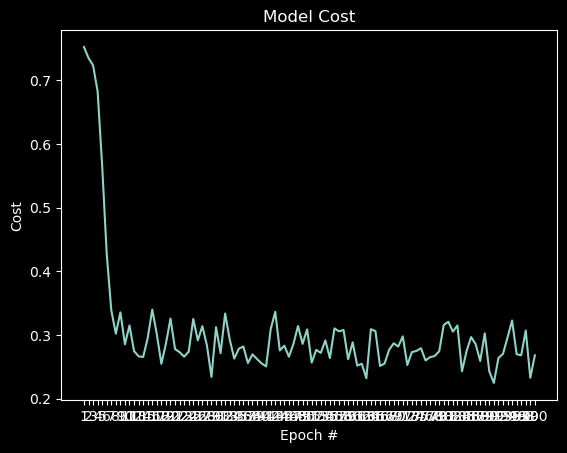

In [42]:
# Plot the losses
loss_plot(losses)

There are so many epochs that the x-ticks are illegible. The slope of the plot follows a much more normal pattern of the loss drastically decreasing in the beginnning epochs before settling in.

In [43]:
eval_model(X2_test, y2_test, layer2)

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      3606
           1       0.00      0.00      0.00       689

    accuracy                           0.84      4295
   macro avg       0.42      0.50      0.46      4295
weighted avg       0.70      0.84      0.77      4295



This is disappointing but not an unsurprising result. The model had classified these initially observations as safe in the first run through and it did the same thing here after I eliminated the more common intrusions. I had hoped that with the more obvious patterns removed that the model could focus on different patterns but it seems that the model is great at picking up patterns and if they didn't exist then it doesn't matter what portion of the data I use.

Below I created a heatmap that compares all of the means of the features of each new intrusion type to the safe observations to see how similar they are. If it is the case that there is no clear difference, than the model won't be able to distinguish between safe and attack.

Index(['mailbomb.', 'mscan.', 'apache2.', 'processtable.', 'saint.'], dtype='object')


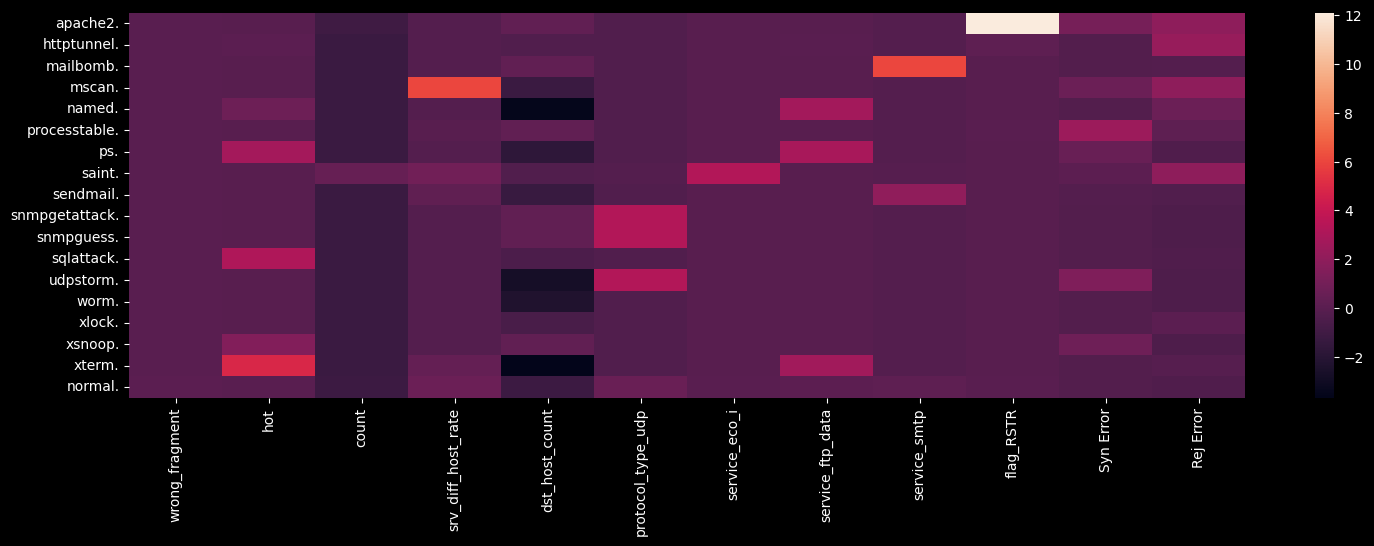

In [63]:
# Create groupby object
normal_mean = pd.DataFrame(small_test.loc[small_test['labels'] == 'normal.'].mean(numeric_only = True), columns = ['normal.'])
# Change the figure size to fit the dataframe
plt.figure(figsize=(18,5))
# filter out all observations that are snmp attacks
snmp = pd.DataFrame(small_test.loc[small_test['labels'].isin(new_attacks)])
grouped = pd.DataFrame(snmp.groupby('labels').mean(numeric_only = True).T)
# combine the two
combined = pd.concat([grouped, normal_mean], axis = 1)
# create a heatmap of the means to visualize it better
sns.heatmap(combined.T);
print(deep_dive.index[:5])

The attack type with the clearest hot spot (apache2) is consistently captured consistently by the model. I printed above the heatmap the 5 new attacks that the model is the best at classifiying. A lot of them have clear differences with the last row of the heat map in some features. When I look as snmp attacks do have differences between them and the safe observation but means could be close enough that the model has now way to effectively differentiate between the two. 

I believe that the reason the model is struggling with these new intrusion types is because when I did lasso regularization, I optimized for only the intrusion types in the training set and not any in the test set. In order to build a better model that would be used for the next round of data. I need to keep optimizing it with all of the relevant features.

Below I repurposed the preprocessing code to create a feature set that is optimized for the intrusions in the test set.

In [13]:
def lassoing(dfx):
    # I copy and pasted the column names from the website into this list
    dfx.columns = ["duration", "protocol_type", "service", "flag", "src_bytes",
                    "dst_bytes", "land", "wrong_fragment", "urgent", "hot",
                    "num_failed_logins", "logged_in", "num_compromised",
                    "root_shell", "su_attempted", "num_root", "num_file_creations",
                    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
                    "is_guest_login", "count", "srv_count", "serror_rate","srv_serror_rate",
                    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
                    "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
                    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", 
                    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "labels"]
    
    # Between 'num_outbound_cmds', and 'is_host_login' there are 2 non zero values both are observations that were both normal.
    # Use the drop methods to get rid of the near constants
    dfx = dfx.drop(columns = ['num_outbound_cmds', 'is_host_login'], axis = 1)
    '''
    Now we separate the data into the feature variables (X) and the target variable (y). With the features dataframe we can use 
    the pd.get_dummies function to create dummy features for all the categories in the categorical columns. This will make it possible 
    to analyze all the features for multicolinearity and then use lasso regularization to determine the most important features.
    '''
    # Only use the X data so that it is easy to test for multicolinearity
    y = np.where(dfx['labels'] == 'normal.', 0, 1)
    # drop the target variable from the feature set
    X_data = dfx.drop('labels', axis = 1)

    # Find the categorical columns that need to be made numerical for analysis
    cat_cols = list(X_data.select_dtypes(include = 'object').columns)

    # Creating a completely numerical dataset that is usable for analysis
    X_data = pd.get_dummies(X_data, columns = cat_cols, 
                            # When testing for multi-co-linearity it is important to drop one of the dummies
                            # so that that column doesn't get flagged
                                drop_first = True)
    
    '''
    Skewed features are a problem as they make it hard for models to accurately describe interactions between different features because
    the arbitrary size of some feature will completely warp the math. To fix this we can scale the features with StandardScaler so as to
    preserve the nature of the feature without destroying the model by its size.
    '''
    # Create the scaler object
    scaler = StandardScaler()
    # fit the scaler to the dataset
    scaler.fit(X_data)
    # Scale the dataset
    X_data = pd.DataFrame(scaler.transform(X_data), columns = X_data.columns)

    '''
    Creating the features 'Syn Error' and 'Rej Error'
    '''
    # Define the Syn Error columns
    serror = ['serror_rate', 'srv_serror_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate']

    # Define the Syn Error columns
    rerror = ['rerror_rate', 'srv_rerror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']

    # Create new Syn Error column as mean of the former Syn Error columns
    X_data['Syn Error'] = X_data[serror].max(axis = 1)


    # Create new Syn Error column as mean of the former Syn Error columns
    X_data['Rej Error'] = X_data[rerror].max(axis = 1)


    # Drop the redundant columns
    X_data = X_data.drop(columns = [*serror, *rerror])
    
    # Find the coefficients of lasso regularization
    lasso = Lasso(alpha = 0.007157894736842105)
    # Fit the lasso regularization to the data 
    lasso.fit(X_data,y)
    # Create a list of all the features that don't have a lasso coefficient of zero
    test_features = [X_data.columns[i] for i in range(len(X_data.columns)) if list(lasso.coef_)[i] != 0]

    # Create the list of all important training features
    train_features = list(X_small.columns)
    # Create join the lists.
    train_test_features = list(set(train_features) | set(test_features))
    # Return the dataset that has only the lasso test features.
    return X_data[train_test_features]

Now I can import the raw test data and run the processing function on it to get a dataset that has all the features that apply to the intrusions in the test set.

In [14]:
# Import the test data
test = pd.read_csv('./data/raw/test')

Opt_test = lassoing(test)
Opt_test.head()

,service_finger,protocol_type_udp,dst_host_same_src_port_rate,dst_host_count,logged_in,service_domain_u,service_urp_i,flag_RSTR,srv_diff_host_rate,Rej Error,...,service_ecr_i,Syn Error,service_pop_3,service_ftp_data,service_eco_i,wrong_fragment,flag_SF,service_http,service_smtp,hot
0,-0.030602,3.263145,-1.113746,0.323696,-0.456536,-0.101312,-0.014234,-0.053023,-0.202418,-0.408486,...,-1.058542,-0.252083,-0.113735,-0.084845,-0.041974,-0.018877,0.502232,-0.390958,-0.165254,-0.047032
1,-0.030602,3.263145,-1.113746,0.323696,-0.456536,-0.101312,-0.014234,-0.053023,-0.202418,-0.408486,...,-1.058542,-0.252083,-0.113735,-0.084845,-0.041974,-0.018877,0.502232,-0.390958,-0.165254,-0.047032
2,-0.030602,3.263145,-1.113746,0.323696,-0.456536,-0.101312,-0.014234,-0.053023,-0.202418,-0.408486,...,-1.058542,-0.252083,-0.113735,-0.084845,-0.041974,-0.018877,0.502232,-0.390958,-0.165254,-0.047032
3,-0.030602,3.263145,-1.093419,0.323696,-0.456536,-0.101312,-0.014234,-0.053023,-0.202418,-0.408486,...,-1.058542,-0.252083,-0.113735,-0.084845,-0.041974,-0.018877,0.502232,-0.390958,-0.165254,-0.047032
4,-0.030602,3.263145,-1.093419,0.323696,-0.456536,-0.101312,-0.014234,-0.053023,-0.202418,-0.408486,...,-1.058542,-0.252083,-0.113735,-0.084845,-0.041974,-0.018877,0.502232,-0.390958,-0.165254,-0.047032


There are 22 columns in Opt_test which is 10 more than were in the small dataset

In [15]:
Xopt_train, X_opt_test, y_opt_tr, y_opt_te = train_test_split(Opt_test, y_test, test_size = 0.25, random_state = 54)

In [16]:
opt_model = train_model(Xopt_train, y_opt_tr, 10, 500, testNet)

In [17]:
eval_model(X_opt_test, y_opt_te, opt_model)

              precision    recall  f1-score   support

           0       0.85      0.99      0.92     15192
           1       1.00      0.96      0.98     62565

    accuracy                           0.96     77757
   macro avg       0.92      0.97      0.95     77757
weighted avg       0.97      0.96      0.97     77757



There is improvement with these new features but it is slight. While this improvement could be increadibly helpful depending on the size of the dataset, it is frustrating to not be able to replicate similar results to the near perfect scores on the test set of the training portion. 

It is always important to keep perspective. If the model was able to predict certain types of attacks really well and struggled with others then that is a lot better than if it had the same overall accuracy but had uniform success with each attack type. With the knowledge that the model struggled with snmp attacks it is possible to install more security around snmp while continuing to use the model for the rest of the intrusions.

Another thing to note is the near perfect precision the model has when it predicts that there is an attack. Having at least one classification that a model can give that a person can put confidence in is valuable.

### **Big Data**
#### **Categorical Models**

As helpful as it to know if there is an attack or not, it would also be helpful to know what kind of attack is happening. To do this I will use the big dataset that is comprised of every feature that has an effect on the type of attack in an observation. 

First I created all the functions that I needed to run a tensorflow model. I tried to run the categorical models on my GPU through Pytorch but the model needed more dedicated memory than my GPU had to offer. As such I switched back to Keras as it is significantly easier and Pytorch had no more benefit.

Below is a function that changes the target variable into something that the model can understand.

In [31]:
def change_labels(y_train):
    global label_encoder
    # Initialize the label encoder
    label_encoder = LabelEncoder()
    # fit and transform the y training data with label encoder
    y_group = label_encoder.fit_transform(y_train['group'])
    # transfrom the encoded data to a categorical variable
    y_group = to_categorical(y_group, num_classes = 8)
    # return the labels for outside the function
    return y_group

This function is the tensorflow model. I started out by giving it the same number of nodes as the dataset had features and a lot of hidden layers. Whenever I call the function I can customize the amount of epochs and the batch size that is used.

In [34]:
def tf_model(X_train, y_train, ep, b_s):
    # Initialize the model
    model = Sequential()

    # Create the first layer of the deep learning model with input set the number of features in X_train
    model.add(Dense(61, activation = 'relu', input_dim = X_train.shape[1]))
    # Add a middle layer to give the model more complexity
    model.add(Dense(61, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(61, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(61, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(61, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(61, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(61, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(61, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(61, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(53, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(38, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(25, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(14, activation = 'relu'))
    # Finish with the same amount of nodes as categories that there are to predict
    model.add(Dense(8, activation = 'softmax'))
    # Compile the network with the standard optimiizer and loss function
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
    # Train the model with X_train and the encoded categorical y_group
    model.fit(X_train.astype('float32'), y_train, epochs = ep, batch_size = b_s)

    return model


This function prints out a classification report and returns the predictions for further use.

In [168]:
def eval_tf(X_test, y_test, model):
    # Create the predictions. This creates an array that has as many columns as potential predictions
    preds = model.predict(X_test)
    # Take the highest prediction as the model's prediction
    pred = preds.argmax(axis = 1)
    # get the intrusions corresponding to the encoder class.
    ints = label_encoder.classes_ # type: ignore
    # Assign each of the predictions to the group that they correspond to
    predictions = [ints[i] for i in pred]
    # Print out the classification report
    print(classification_report(y_test['group'], predictions, zero_division = 0))
    # return the predictions for further analysis
    return predictions

Run train_test_split on the function so that it split up the training data into training and then cross validation.

In [170]:
# Create a train and test data from the full dataset
X_train, X_test, y_tr, y_te = train_test_split(X_big, small_train[['labels','group']], test_size = .25)

Change the labels with label_encoder so that the model is able to use them.

In [171]:
y_group = change_labels(y_tr)

Train the model with train portion of the training set.

In [172]:
bignet = tf_model(X_train, y_group, 2, 5000)

Epoch 1/2
735/735 [==============================] - 70s 93ms/step - loss: 0.0834 - categorical_accuracy: 0.9867
Epoch 2/2
735/735 [==============================] - 68s 92ms/step - loss: 0.0036 - categorical_accuracy: 0.9992


The categorical accuracy is so high that I didn't think that it was necessary to run more than two epoch.

In [173]:
# Evaluate the model and store the predictions in the variable cat_preds
cat_preds = eval_tf(X_test, y_te, bignet)
# Print out every attack type that the model predicted.
print(f'Attack types that the model predicted: {list(set(cat_preds))}') 

38269/38269 [==============================] - 70s 2ms/step
              precision    recall  f1-score   support

 brute force       0.00      0.00      0.00        23
       files       0.00      0.00      0.00         2
    internal       1.00      1.00      1.00    702725
        none       1.00      1.00      1.00    243182
       pings       1.00      1.00      1.00    268044
     scripts       0.00      0.00      0.00         6
      sweeps       0.99      0.98      0.99     10343
       warez       0.00      0.00      0.00       283

    accuracy                           1.00   1224608
   macro avg       0.50      0.50      0.50   1224608
weighted avg       1.00      1.00      1.00   1224608

Attack types that the model predicted: ['sweeps', 'internal', 'none', 'pings']


In [126]:
deep_dive = ints_eval(cat_preds, y_te, multi = True, new_int = False)
deep_dive

100%|██████████| 1224608/1224608 [01:02<00:00, 19741.46it/s]


,Correct,Wrong,Net,% Correct
smurf.,701913,197,701716,100.0
teardrop.,267,0,267,100.0
pod.,69,0,69,100.0
normal.,242441,583,241858,99.8
neptune.,267286,758,266528,99.7
ipsweep.,3130,24,3106,99.2
portsweep.,2543,28,2515,98.9
satan.,3872,62,3810,98.4
nmap.,533,73,460,88.0
back.,443,98,345,81.9


The model is near perfect for every single group that has over 10,000 observations. I'm curious if I take every predictions from the groups that had 100% precision if I will be able to see if the model can more accurately predict the rarer types.

Overall the neural networks were amazing at predicting intrusion types that had already happened. If this model was to be used at a security firm than the more diverse set of intrusions that it was allowed to train on the better it would do. Unfortunately there are a set of attacks that without training data is impossible for this model to catch. I don't know if there is a better way to train the model to catch them.

The one thing that I wish I had done better was to get the model to generate more rare events. Given the size of the dataset and the rarety of some of the intrusion types the models just ignored those types and stuck with the more common intrusion types. If I had weighted the model and created some synthetic data with some of the rarer intrusion types that might have helped the model predict all intrusion types.

In [129]:
y_group = change_labels(small_train)
bigNet = tf_model(X_big, y_group, 2, 5000)

Epoch 1/2
980/980 [==============================] - 55s 54ms/step - loss: 0.0794 - categorical_accuracy: 0.9706
Epoch 2/2
980/980 [==============================] - 51s 51ms/step - loss: 0.0045 - categorical_accuracy: 0.9991


In [130]:
cattest = eval_tf(X_big_test, small_test['group'], bigNet)

9720/9720 [==============================] - 26s 3ms/step
              precision    recall  f1-score   support

 brute force       0.00      0.00      0.00      7574
       files       0.00      0.00      0.00         5
    internal       0.95      1.00      0.97    165217
        none       0.71      0.87      0.78     60592
       pings       0.98      0.90      0.94     63109
     scripts       0.00      0.00      0.00      8763
      sweeps       0.63      0.70      0.67      4166
       warez       0.83      0.23      0.37      1602

    accuracy                           0.89    311028
   macro avg       0.51      0.46      0.47    311028
weighted avg       0.85      0.89      0.87    311028



In [131]:
bigNet.save('./models/bigNet.h5')

In [141]:
deep_dive = ints_eval(cattest, small_test[['labels','group']], multi = True, new_int = False)
deep_dive

100%|██████████| 311028/311028 [00:16<00:00, 19270.00it/s]


,Correct,Wrong,Net,% Correct
smurf.,164066,25,164041,100.0
nmap.,84,0,84,100.0
teardrop.,12,0,12,100.0
portsweep.,351,3,348,99.2
neptune.,56722,1279,55443,97.8
ipsweep.,297,9,288,97.1
saint.,702,34,668,95.4
back.,1045,53,992,95.2
pod.,81,6,75,93.1
normal.,52593,7999,44594,86.8


The model consistently overperforms for certain types of attacks but underperforms for others. It is the same problem as with the small dataset. It makes sense that this happens because when I had created a test specific dataset, it had limited improvements. The 49 extra features were not able to give the model more information on classifying the intrusion.

## **Random Forrests**

The second type of model that I will use is a random forrest which is an ensemble method of decision trees. The idea is that since hacking is an inherently human act, the process should follow some sort of decision tree where the features values should represent the decisions that the person made to lead to a given intrusion. 

Below I run a grid search to find the optimal amount of trees for the forrest

In [61]:
# Initialize a random forest model
rf = RandomForestClassifier(n_jobs = 4)
# Create a set of values to search
param_grid = {'n_estimators': [5, 50, 100, 150, 200, 300, 600]}  
# Create the grid search object with 5 cross validational folds
grid_search = GridSearchCV(rf, param_grid, cv = 2, verbose = 1)  
# Fit the data to the grid search
grid_search.fit(X_small, y_train)
# Save the best parameters  
best_params = grid_search.best_params_
# Print the best parameters
best_params

Fitting 2 folds for each of 2 candidates, totalling 4 fits


{'n_estimators': 300}

Now I use train test split to perform the same separation of data as I did for the first neural network.

In [145]:
# Create a train and test data from the 12 feature dataset
X_train, X_test, y_tr, y_te = train_test_split(X_small, y_train['Binary'], test_size = .25, random_state = 42)

Run the decision trees with the 300 trees as dicovered by the grid search

In [146]:
# Create a random forest classifier with the best parameters trees
rf = RandomForestClassifier(n_estimators= 300, n_jobs = 4)

# Fit the model to the data
rf.fit(X_train, y_tr)

# Predict the test set
rf_pred = rf.predict(X_test)

# print the classification report
print(classification_report(y_te, rf_pred, zero_division = 0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    243103
           1       1.00      1.00      1.00    981505

    accuracy                           1.00   1224608
   macro avg       1.00      1.00      1.00   1224608
weighted avg       1.00      1.00      1.00   1224608



It is interesting that the random forest was able to get the same result as the neural network. It shows that there was clearly decipherable patterns in the training data that these models were able to pick up on.

In [149]:
# Create a random forest classifier with the best parameters trees
rf = RandomForestClassifier(n_estimators= 300, n_jobs = 4)

# Fit the model to the data
rf.fit(X_small, y_train['Binary'])

# Predict the test set
rf_pred = rf.predict(X_small_test)

# print the classification report
print(classification_report(y_test['Binary'], rf_pred, zero_division = 0))

              precision    recall  f1-score   support

           0       0.70      0.85      0.76     60592
           1       0.96      0.91      0.94    250436

    accuracy                           0.90    311028
   macro avg       0.83      0.88      0.85    311028
weighted avg       0.91      0.90      0.90    311028



Both models struggled when moving to the official test set. This is slightly worse than the neural network but it is very close. It could be that If the hyper parameters were correctly tuned that the results would be better. 

Below I examined which intrusion types the model struggled with.

In [155]:
rf_deep_dive = ints_eval(rf_pred, y_test, new_int = False)
rf_deep_dive

100%|██████████| 311028/311028 [00:17<00:00, 17315.45it/s]


,Correct,Wrong,Net,% Correct
smurf.,164062,29,164033,100.0
neptune.,58001,0,58001,100.0
portsweep.,354,0,354,100.0
nmap.,84,0,84,100.0
teardrop.,12,0,12,100.0
land.,9,0,9,100.0
loadmodule.,2,0,2,100.0
imap.,1,0,1,100.0
apache2.,792,2,790,99.7
ipsweep.,303,3,300,99.0


The model struggled in the exact same way that the neural network did. It is possible that with perfect hyper-parameter tuning they would be equal or the random forrest would be better but as it stands now the random forrest is still slightly worse.

#### **Categorical Random Forrest**

In [175]:
# Initialize the label encoder
label_encoder = LabelEncoder()
# fit and transform y_group
y_group = label_encoder.fit_transform(small_train['group']) #type: ignore
# Transform the y_group variable to a categorical variable
y_group = to_categorical(y_group, num_classes = 8)


# Create a random forest classifier with 300 trees
rf = RandomForestClassifier(n_estimators=300, n_jobs = 4)

# Fit the model to the data
rf.fit(X_big, y_group)

# Predict the test dataset with the previous model
preds = rf.predict(X_big_test)
# Find the prediction that the model likes the most
pred = preds.argmax(axis = 1)
# Get the corresponding group types from label_encoder
ints = label_encoder.classes_
# find the intrusions for each prediction
predictions = [ints[i] for i in pred]
# Print the classification report
print(classification_report(small_test['group'], predictions, zero_division = 0))


              precision    recall  f1-score   support

 brute force       0.03      0.25      0.05      7574
       files       0.00      0.00      0.00         5
    internal       1.00      0.00      0.00    165217
        none       0.21      0.79      0.34     60592
       pings       0.98      0.28      0.43     63109
     scripts       0.00      0.00      0.00      8763
      sweeps       0.78      0.72      0.75      4166
       warez       1.00      0.13      0.23      1602

    accuracy                           0.23    311028
   macro avg       0.50      0.27      0.23    311028
weighted avg       0.79      0.23      0.17    311028



In [263]:
np.unique(predictions, return_counts = True)

(array(['brute force', 'internal', 'none', 'pings', 'sweeps', 'warez'],
       dtype='<U11'),
 array([ 64682,     78, 224330,  17869,   3856,    213], dtype=int64))

This is significantly worse than the neural net version of a categorical prediction. I don't know why the decision tree would be so bad at categorical predictions given that it was very similar in all the other ways that it was used. Interestingly it did end up giving more types of predictions than the neural network but overall the predictions were bad.

Below I have the table to see how well it did at predicting each intrusion type.

In [184]:
rf_deep_dive = ints_eval(predictions, small_test[['labels','group']], multi = True, new_int = False)
rf_deep_dive

100%|██████████| 311028/311028 [00:08<00:00, 35279.77it/s]


,Correct,Wrong,Net,% Correct
portsweep.,353,1,352,99.7
satan.,1625,8,1617,99.5
nmap.,80,4,76,95.2
saint.,673,63,610,91.4
normal.,48027,12565,35462,79.3
processtable.,389,370,19,51.3
udpstorm.,1,1,0,50.0
snmpguess.,1162,1244,-82,48.3
multihop.,8,10,-2,44.4
land.,4,5,-1,44.4


## **Conclusion**



The classifiers that I built were good because of all the work that I put in in the first three stages of the project. At the start of the project the goal was to build classifiers that were able to differentiate intrusions better than at worst a coin flip and at best a null classifier. The models that I built went way past that goal. Initially I was only working with a tenth of the dataset and I though that I was going to split that up into training and test sets. If that were the case I would have built near perfect classifiers with both the neural network and the decision tree.

With the entire dataset and the official test set I was able to test the model to see how good it was. There was a presumption of success with the training data but it was important to see how well the models it performed on their own. Without comparing the test set results to the training set results the models did well. I believed that I could make them do better so that if there ever was more data to come that newer model would be even better. Unfortunately I was unable to signficantly improve the model past the initial point but I'm sure that if I had more time to work on it there would be a plethora of different ways to continue to analyze this data.